Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [101]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow_datasets as tfds
from tensorflow import keras
from glob import glob
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping

### This is executed in google colab to utilize GPU services

In [70]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [72]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

# Defining the path for train and test images
train_path = "/content/drive/MyDrive/content/gdrive/data/Train/"
test_path="/content/drive/MyDrive/content/gdrive//data/Test/"
data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [73]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Create a dataset

Define some parameters for the loader:

In [74]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [75]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, image_size=(img_height, img_width), batch_size=batch_size, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', shuffle=True, seed=123, validation_split=0.1, subset='training',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2239 files belonging to 9 classes.
Using 2016 files for training.


In [76]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, image_size=(img_height, img_width), batch_size=batch_size, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', shuffle=True, seed=123, validation_split=0.1, subset='validation',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2239 files belonging to 9 classes.
Using 223 files for validation.


In [77]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualize one instance of all the nine classes present in the dataset

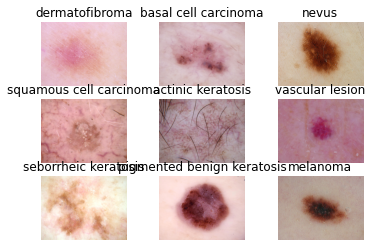

In [78]:
import matplotlib.pyplot as plt
num=0
for dirpath, dirnames, filenames in os.walk(str(train_path)):
    for filename in [f for f in filenames if f.endswith(".jpg")][:1]:
        img = PIL.Image.open(str(dirpath)+"/"+str(filename))
        plt.subplot(3,3,num+1)
        plt.title(str(dirpath).split('/')[-1])
        plt.axis('off')
        plt.imshow(img)
        num=num+1

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [79]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [80]:
print(train_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>


### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [60]:
# Model 1
model = Sequential([
        tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255, offset=0.0),

        Conv2D(32, (3,3), input_shape=(img_height, img_width, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.1),

        Conv2D(64, (3,3), input_shape=(img_height, img_width, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.1),

        Flatten(),
        Dense(128, activation='relu'),
        Dense(9, activation='softmax')
])

In [61]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [62]:
# Train the model
epochs_cnt = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs_cnt)

Epoch 1/20
63/63 [==============================] - 21s 286ms/step - loss: 2.6464 - accuracy: 0.2728 - val_loss: 1.8587 - val_accuracy: 0.3722
Epoch 2/20
63/63 [==============================] - 15s 237ms/step - loss: 1.6207 - accuracy: 0.4449 - val_loss: 1.8051 - val_accuracy: 0.3767
Epoch 3/20
63/63 [==============================] - 15s 238ms/step - loss: 1.4615 - accuracy: 0.4916 - val_loss: 1.5919 - val_accuracy: 0.4753
Epoch 4/20
63/63 [==============================] - 15s 237ms/step - loss: 1.3872 - accuracy: 0.5079 - val_loss: 1.5746 - val_accuracy: 0.4619
Epoch 5/20
63/63 [==============================] - 15s 235ms/step - loss: 1.2879 - accuracy: 0.5620 - val_loss: 1.5328 - val_accuracy: 0.4933
Epoch 6/20
63/63 [==============================] - 15s 236ms/step - loss: 1.2021 - accuracy: 0.5813 - val_loss: 1.4681 - val_accuracy: 0.4798
Epoch 7/20
63/63 [==============================] - 15s 236ms/step - loss: 1.1096 - accuracy: 0.6215 - val_loss: 1.4353 - val_accuracy: 0.4978

In [63]:
#analyze the model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 90, 90, 32)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                 

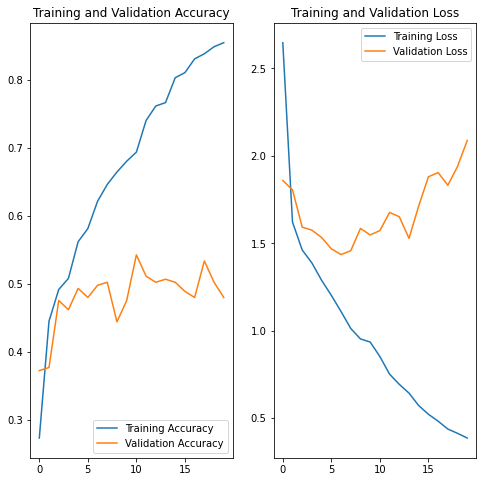

In [64]:
# Visualize accuracy of the above model

accuracy = history.history['accuracy']
valdation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range = range(epochs_cnt)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, valdation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
### Model Analysis
# The training accuracy is as high as 85% but the test accuracy is around 48%
# The training loss is very low where as test loss is very high
# This shows clear over fit with above model.

In [81]:
## Model 2
#here we try to another model by tuning few parameters

model_1 = Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),
    
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),
    Dense(9, activation='softmax')
])

In [82]:
#Compile the model
model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [83]:
#Fit the model and epochs to be set as 20
epochs = 20
model_1_hist = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
63/63 [==============================] - 66s 993ms/step - loss: 2.2262 - accuracy: 0.1776 - val_loss: 2.0430 - val_accuracy: 0.1794
Epoch 2/20
63/63 [==============================] - 62s 986ms/step - loss: 2.0258 - accuracy: 0.1840 - val_loss: 2.0372 - val_accuracy: 0.1794
Epoch 3/20
63/63 [==============================] - 61s 967ms/step - loss: 2.0175 - accuracy: 0.2123 - val_loss: 1.9964 - val_accuracy: 0.2377
Epoch 4/20
63/63 [==============================] - 62s 977ms/step - loss: 1.8999 - accuracy: 0.2763 - val_loss: 1.9761 - val_accuracy: 0.2152
Epoch 5/20
63/63 [==============================] - 62s 990ms/step - loss: 1.7905 - accuracy: 0.3378 - val_loss: 1.7390 - val_accuracy: 0.3632
Epoch 6/20
63/63 [==============================] - 62s 991ms/step - loss: 1.6785 - accuracy: 0.4008 - val_loss: 1.6749 - val_accuracy: 0.3812
Epoch 7/20
63/63 [==============================] - 62s 986ms/step - loss: 1.6978 - accuracy: 0.3695 - val_loss: 1.6607 - val_accuracy: 0.3812

In [84]:
### Todo, choose an appropirate optimiser and loss function
model_1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_34 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_35 (Conv2D)          (None, 178, 178, 32)      9248      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 89, 89, 32)        0         
                                                                 
 conv2d_36 (Conv2D)          (None, 89, 89, 64)        18496     
                                                      

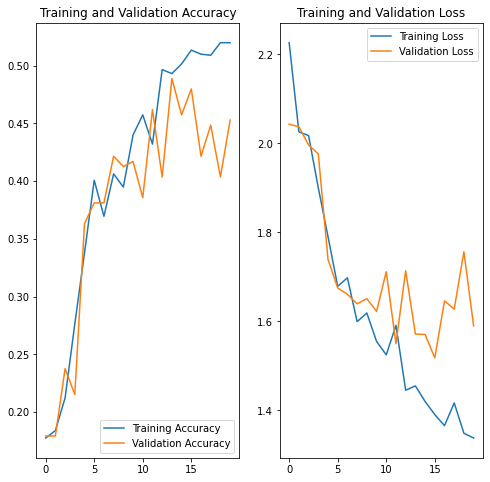

In [85]:
# Visualize accuracy of the above model

accuracy = model_1_hist.history['accuracy']
valdation_accuracy = model_1_hist.history['val_accuracy']

loss = model_1_hist.history['loss']
validation_loss = model_1_hist.history['val_loss']

epochs_range = range(epochs_cnt)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, valdation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model Analysis
#### The training accuracy is as high as 51% but the test accuracy is around 45%
#### The training loss is very low where as test loss is very high
#### This shows clear over fit with above model. There's no improvement in the accuracy.

### Data Augmentation

In [86]:
### Specifying data augmentation
data_augmentation=tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(factor=0.2)
])

### Visualizing the Augmented Data

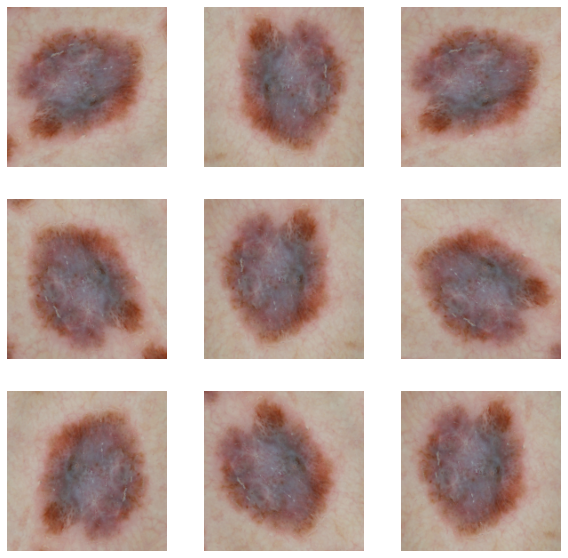

In [87]:
image, label = next(iter(train_ds))
image=np.array(image,np.int32)  
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  augmented_image1=np.array(augmented_image[0],np.int32)  
  plt.imshow((augmented_image1))
  plt.axis("off")

#### Create a model along with Data Augmentation.

### Create MODEL 3 - AUGMENTATION

In [90]:
# Create Model with Data Augmentation

model_data_augmented=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         

    data_augmentation,

    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

In [92]:
# Compiling the data augmented model

model_data_augmented.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

### Training the data augmented model


In [93]:
## ## Your code goes here, note: train your model for 20 epochs
epochs = 20
# simple early stopping
#early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history_data_augmented = model_data_augmented.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
#  callbacks=[early_stop]
)

Epoch 1/20
63/63 [==============================] - 63s 980ms/step - loss: 2.2616 - accuracy: 0.1711 - val_loss: 2.0503 - val_accuracy: 0.1794
Epoch 2/20
63/63 [==============================] - 62s 978ms/step - loss: 2.0393 - accuracy: 0.1935 - val_loss: 2.0378 - val_accuracy: 0.2108
Epoch 3/20
63/63 [==============================] - 61s 970ms/step - loss: 2.0355 - accuracy: 0.1939 - val_loss: 2.0370 - val_accuracy: 0.2108
Epoch 4/20
63/63 [==============================] - 61s 973ms/step - loss: 2.0321 - accuracy: 0.1969 - val_loss: 2.0400 - val_accuracy: 0.1794
Epoch 5/20
63/63 [==============================] - 62s 982ms/step - loss: 2.0232 - accuracy: 0.2009 - val_loss: 2.0204 - val_accuracy: 0.2242
Epoch 6/20
63/63 [==============================] - 62s 982ms/step - loss: 1.9593 - accuracy: 0.2629 - val_loss: 1.8231 - val_accuracy: 0.3318
Epoch 7/20
63/63 [==============================] - 61s 974ms/step - loss: 1.8593 - accuracy: 0.3165 - val_loss: 1.7066 - val_accuracy: 0.3632

### Data Augmented Model Summary

In [94]:
## Your code goes here
model_data_augmented.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_8 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_46 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_47 (Conv2D)          (None, 178, 178, 32)      9248      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 89, 89, 32)        0         
                                                     

### Data Augmented Model Accuracy Analysis

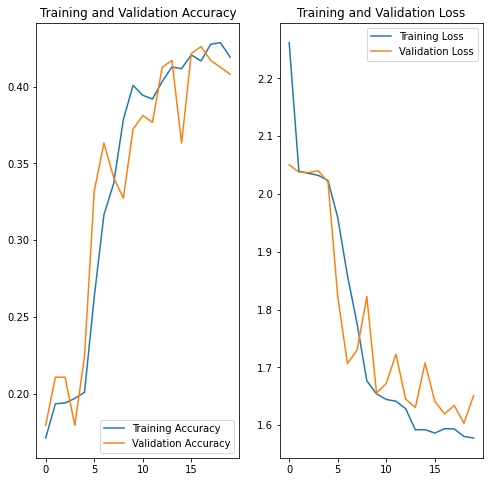

In [95]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
accuracy = history_data_augmented.history['accuracy']
valdation_accuracy = history_data_augmented.history['val_accuracy']

loss = history_data_augmented.history['loss']
validation_loss = history_data_augmented.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, valdation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model Accuracy Observations - 


In [ ]:
# The training accuracy is as high as 41% but the test accuracy is around 40%
# This shows overfit is reduced greatly to an extent when compared to previous models.
# Data Augmentation has shown definite improvement in reducing overfit.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [96]:
## Your code goes here.

for i in class_names:
    directory =train_path+i+'/'
    class_directory = pathlib.Path(directory)
    length=len(list(class_directory.glob('*.jpg')))
    print(f'{i} has {length} samples.')

actinic keratosis has 114 samples.
basal cell carcinoma has 376 samples.
dermatofibroma has 95 samples.
melanoma has 438 samples.
nevus has 357 samples.
pigmented benign keratosis has 462 samples.
seborrheic keratosis has 77 samples.
squamous cell carcinoma has 181 samples.
vascular lesion has 139 samples.


#### Analysis of Imbalanced Data: 
#### - seborrheic keratosis has least number of samples i.e, 77
#### - pigmented benign keratosis has more samples compared to other ones i.e, 462.
#### - This shows there's significant data imabalance.


####  Rectify the class imbalance
#### We have used python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [97]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [98]:
path_to_training_dataset=train_path
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(650) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/content/gdrive/data/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9E06156FD0>: 100%|██████████| 650/650 [00:03<00:00, 199.10 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/content/gdrive/data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9DF2FA8190>: 100%|██████████| 650/650 [00:03<00:00, 193.60 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/content/gdrive/data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9E038A3650>: 100%|██████████| 650/650 [00:03<00:00, 201.81 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/content/gdrive/data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9E06AB0AD0>: 100%|██████████| 650/650 [00:08<00:00, 72.90 Samples/s] 


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/content/gdrive/data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2101x1943 at 0x7F9E03B52310>: 100%|██████████| 650/650 [00:07<00:00, 89.14 Samples/s] 


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/content/gdrive/data/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9E03D167D0>: 100%|██████████| 650/650 [00:03<00:00, 171.66 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/content/gdrive/data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9E312D0D50>: 100%|██████████| 650/650 [00:04<00:00, 137.55 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/content/gdrive/data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9E31308D90>: 100%|██████████| 650/650 [00:03<00:00, 195.73 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/content/gdrive/data/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9DF2C6EA90>: 100%|██████████| 650/650 [00:03<00:00, 200.37 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [99]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

5850


### Lets see the distribution of augmented data after adding new images to the original training data.

In [102]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/content/gdrive/data/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029783.jpg_da46962a-bba8-47b7-881d-3165a7a8e8d4.jpg',
 '/content/drive/MyDrive/content/gdrive/data/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031429.jpg_5559eb16-6596-44f9-b8b2-82c4c4a7b9d7.jpg',
 '/content/drive/MyDrive/content/gdrive/data/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031735.jpg_c25f1ae9-08e6-4c58-bf1d-29d58aefc53c.jpg',
 '/content/drive/MyDrive/content/gdrive/data/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029578.jpg_502d4779-fff5-453c-81b4-457ae81c9c7c.jpg',
 '/content/drive/MyDrive/content/gdrive/data/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032468.jpg_3dd07f56-fdc8-457f-b875-d36a39cb0875.jpg',
 '/content/drive/MyDrive/content/gdrive/data/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025911.jpg_9a583d6d-2b88-4983-8f66-3d4846652c61.jpg',
 '/content/drive/MyDrive/content/gdrive/data/Train/dermato

In [103]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [105]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [107]:
for i in class_names:
    directory =train_path+i+'/'
    directory_out =train_path+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 764 samples.
basal cell carcinoma has 1026 samples.
dermatofibroma has 745 samples.
melanoma has 1088 samples.
nevus has 1007 samples.
pigmented benign keratosis has 1112 samples.
seborrheic keratosis has 727 samples.
squamous cell carcinoma has 831 samples.
vascular lesion has 789 samples.


In [108]:
## Observations:
# The class imbalancing fix as shown above, definitely improved by adding more images to minority classes.
# So, now we have added 650 images to all the classes to maintain some class balance.
# We can add more images as we want to improve training process.


#### Train the model on the data created using Augmentor

In [109]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [143]:
data_dir_train=train_path
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  label_mode='categorical',
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8089 files belonging to 9 classes.
Using 6472 files for training.


#### Create a validation dataset

In [144]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8089 files belonging to 9 classes.
Using 1617 files for validation.


#### Create your model (make sure to include normalization)

In [145]:
model_final_verify=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
    
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [146]:
model_final_verify.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

#### Train your model

In [147]:
epochs_final_exec = 30

In [148]:
## Your code goes here, use 30 epochs.
history_data_final = model_final_verify.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs_final_exec
)

Epoch 1/30
203/203 [==============================] - 50s 242ms/step - loss: 2.4233 - accuracy: 0.1426 - val_loss: 2.1885 - val_accuracy: 0.1293
Epoch 2/30
203/203 [==============================] - 49s 240ms/step - loss: 2.1847 - accuracy: 0.1415 - val_loss: 2.1273 - val_accuracy: 0.1744
Epoch 3/30
203/203 [==============================] - 49s 240ms/step - loss: 1.9070 - accuracy: 0.2845 - val_loss: 1.6104 - val_accuracy: 0.3840
Epoch 4/30
203/203 [==============================] - 49s 240ms/step - loss: 1.4906 - accuracy: 0.4323 - val_loss: 1.3006 - val_accuracy: 0.5121
Epoch 5/30
203/203 [==============================] - 49s 240ms/step - loss: 1.2657 - accuracy: 0.5249 - val_loss: 1.1674 - val_accuracy: 0.5844
Epoch 6/30
203/203 [==============================] - 49s 240ms/step - loss: 1.1046 - accuracy: 0.5943 - val_loss: 1.0496 - val_accuracy: 0.6098
Epoch 7/30
203/203 [==============================] - 49s 240ms/step - loss: 0.9635 - accuracy: 0.6550 - val_loss: 0.9400 - val_ac

#### Visualize the model results

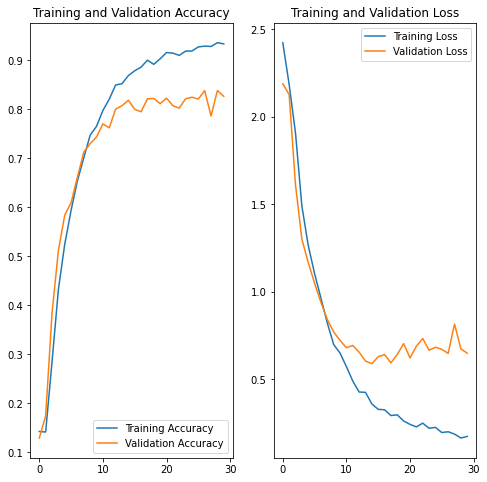

In [149]:
acc = history_data_final.history['accuracy']
val_acc = history_data_final.history['val_accuracy']

loss = history_data_final.history['loss']
val_loss = history_data_final.history['val_loss']

epochs_range = range(epochs_final_exec)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analysis - on final model build.



### Final Observations

#### The training accuracy looks approximately equal to 93%.
#### The validation accuracy looks approximately equal to 83%.
#### The model accuracy is overall improved and overfitting has greatly reduced with help of Class Imbalancing.
#### Further this model can be improved with adding more layers and increasing number of epochs.

#### Notebook Prepared by Balakumar Seethapathy